In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
import re

from collections import defaultdict
from scipy.stats import ttest_ind

FPS = 60

## Load data

In [123]:
# Path to the .h5 file
file_path = '../syllable_analysis_julia/results.h5'

# Initialize a dictionary to hold dfs for each Mouse ID
include_latent_state = False

# Using defaultdict in case there are multiple groups per Mouse ID
dfs = defaultdict(list)

# Regular expression pattern to extract Mouse ID
# Assumes Mouse ID is the number before 'DLC' in the group name
mouse_id_pattern = re.compile(r'_(\d+)DLC_')

with h5py.File(file_path, 'r') as file:
    for group_name in file.keys():
        # Extract Mouse ID using regex
        match = mouse_id_pattern.search(group_name)
        if match:
            mouse_id = match.group(1)
        else:
            # Handle cases where Mouse ID is not found
            print(f"Warning: Mouse ID not found in group name '{group_name}'. Skipping this group.")
            continue  # Skip this group
        
        # Check if Mouse ID already exists in the dictionary (this would indicate an error)
        if mouse_id in dfs:
            raise ValueError(f"Error: Multiple groups found for Mouse ID '{mouse_id}' in the file. Only one group per Mouse ID is expected.")
        
        group = file[group_name]
        
        # List to hold individual DataFrames for each dataset
        df_list = []
        
        for dataset_name in group.keys():
            # Exclude 'latent_state' datasets if the flag is False
            if not include_latent_state and dataset_name.startswith('latent_state'):
                continue
            
            dataset = group[dataset_name][:]
            
            # Check if dataset is at least 1D
            if dataset.ndim == 1:
                # Convert to 2D array with one column
                dataset = dataset.reshape(-1, 1)
            
            # Create column names by appending index to dataset name
            # Example: 'centroid_0', 'centroid_1', ...
            num_cols = dataset.shape[1]
            columns = [f"{dataset_name}_{i}" for i in range(num_cols)]
            
            # Convert dataset to DataFrame
            df = pd.DataFrame(dataset, columns=columns)
            df_list.append(df)
        
        if df_list:
            # Concatenate all DataFrames horizontally (axis=1)
            concatenated_df = pd.concat(df_list, axis=1)
            # Add to the dictionary with the Mouse ID as the key
            dfs[mouse_id] = concatenated_df
        else:
            print(f"Warning: No datasets found in group '{group_name}'.")

## Prepare data

In [124]:
for df in dfs.values():
    df['timestamp'] = df.index / FPS
    df['current_minute'] = df['timestamp'] / 60

In [125]:
syllable_info = pd.read_csv('../syllable_analysis_julia/syllable,behavior_group.csv', index_col=0)
#pd.read_csv('../syllable_analysis_julia/syllable,behavior.csv', index_col=0)
syllable_info.loc[41] = 'faulty'
syllable_map = syllable_info.to_dict()['behavior']

mouse_info = pd.read_csv('../syllable_analysis_julia/syllables_mouseCoh1_info.csv', index_col=0)

In [126]:
for df in dfs.values():
    df['syllable_name'] = df['syllable_0'].map(syllable_map)
    df['syllable_name'] = df['syllable_name'].fillna('faulty')  # Replace NaN with 'faulty'


## Split by injection

In [127]:
def split_df_by_injection(df, mouse_id):
    # Get the relevant time intervals from the mouse_info DataFrame
    pre_inj_start, pre_inj_end, post_inj_start, post_inj_end = \
        mouse_info.loc[mouse_id][['PreInjStart', 'PreInjEnd', 'PostInjStart', 'PostInjEnd']].to_list()

    post_inj_end -= 30
    # Filter DataFrame based on the current_minute column for pre-injection
    pre_inj_df = df[(np.floor(df['current_minute']) >= pre_inj_start) & (np.ceil(df['current_minute']) <= pre_inj_end)]
    
    # Filter DataFrame based on the current_minute column for post-injection
    post_inj_df = df[(np.floor(df['current_minute']) >= post_inj_start) & (np.ceil(df['current_minute']) <= post_inj_end)]

    return pre_inj_df, post_inj_df

In [128]:
dfs_split = defaultdict(list)

for mouse_id, df in dfs.items():
    genotype, side = list(mouse_info.loc[int(mouse_id)])[:2]
    pre_inj_df, post_inj_df = split_df_by_injection(df, int(mouse_id))

    dfs_split[(mouse_id, 'pre', genotype, side)] = pre_inj_df
    dfs_split[(mouse_id, 'post', genotype, side)] = post_inj_df

In [129]:
for k, v in dfs_split.items():
    print(k, len(v))

('222', 'pre', 'Het', 'Left') 216001
('222', 'post', 'Het', 'Left') 216001
('237', 'pre', 'Het', 'Left') 216001
('237', 'post', 'Het', 'Left') 216001
('218', 'pre', 'Het', 'Left') 216001
('218', 'post', 'Het', 'Left') 216001
('210', 'pre', 'WT', 'Left') 216001
('210', 'post', 'WT', 'Left') 216001
('220', 'pre', 'Het', 'Right') 216001
('220', 'post', 'Het', 'Right') 216001
('243', 'pre', 'WT', 'Right') 216001
('243', 'post', 'WT', 'Right') 216001
('208', 'pre', 'WT', 'Right') 216001
('208', 'post', 'WT', 'Right') 216001
('202', 'pre', 'Het', 'Right') 216001
('202', 'post', 'Het', 'Right') 216001


## Calculate angular parameters

In [130]:
def compute_angular_velocity(df):
    # Unwrap the heading angles to prevent discontinuities
    df.loc[:, 'unwrapped_heading'] = np.unwrap(df['heading_0'])  # Use .loc[] to avoid the warning
    # Compute time differences
    df.loc[:, 'time_diff'] = df['timestamp'].diff().fillna(0)
    # Compute heading differences
    df.loc[:, 'heading_diff'] = df['unwrapped_heading'].diff().fillna(0)
    # Compute angular velocity
    df.loc[:, 'angular_velocity'] = df['heading_diff'] / df['time_diff']
    return df

In [131]:
# Apply the function to all DataFrames in dfs
for key, df in dfs.items():
    dfs[key] = compute_angular_velocity(df)  # Reassign the result to the original DataFrame

# Apply the function to all DataFrames in dfs_split
for key, df in dfs_split.items():
    dfs_split[key] = compute_angular_velocity(df)  # Reassign the result to the original DataFrame


/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_6928/579445921.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'unwrapped_heading'] = np.unwrap(df['heading_0'])  # Use .loc[] to avoid the warning
/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_6928/579445921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'time_diff'] = df['timestamp'].diff().fillna(0)
/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_6928/579445921.py:7: SettingWithCopyWarning: 
A 

In [132]:
def remove_outliers_zscore_replace(df, threshold=3):
    # Calculate mean and standard deviation
    mean = df['angular_velocity'].mean()
    std = df['angular_velocity'].std()
    
    # Define upper and lower bounds based on the threshold
    upper_bound = mean + threshold * std
    lower_bound = mean - threshold * std
    
    # Replace outliers with the upper or lower bound using .loc[] to avoid warnings
    df.loc[:, 'angular_velocity_clean'] = df['angular_velocity'].clip(lower=lower_bound, upper=upper_bound)
    
    return df

In [133]:
# Apply the function to all DataFrames in dfs
for key, df in dfs.items():
    dfs[key] = remove_outliers_zscore_replace(df, threshold=3)

# Apply the function to all DataFrames in dfs_split
for key, df in dfs_split.items():
    dfs_split[key] = remove_outliers_zscore_replace(df, threshold=3)

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_6928/1311355301.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'angular_velocity_clean'] = df['angular_velocity'].clip(lower=lower_bound, upper=upper_bound)
/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_6928/1311355301.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'angular_velocity_clean'] = df['angular_velocity'].clip(lower=lower_bound, upper=upper_bound)
/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T

In [134]:
for k, df in dfs_split.items():
    print(k, -df['angular_velocity_clean'].sum()/6.28)

('222', 'pre', 'Het', 'Left') 139.6640503359574
('222', 'post', 'Het', 'Left') 23233.412948343823
('237', 'pre', 'Het', 'Left') -676.0893021782897
('237', 'post', 'Het', 'Left') 15300.804165803438
('218', 'pre', 'Het', 'Left') -1190.605926242014
('218', 'post', 'Het', 'Left') -2906.9576924717676
('210', 'pre', 'WT', 'Left') -857.1286011055828
('210', 'post', 'WT', 'Left') -6397.281465850637
('220', 'pre', 'Het', 'Right') -1157.0428286397782
('220', 'post', 'Het', 'Right') -8101.144701570565
('243', 'pre', 'WT', 'Right') 744.987211116116
('243', 'post', 'WT', 'Right') -11721.301279854248
('208', 'pre', 'WT', 'Right') -775.832943730043
('208', 'post', 'WT', 'Right') 3831.8031456723243
('202', 'pre', 'Het', 'Right') 660.6680199873292
('202', 'post', 'Het', 'Right') 28491.40320481419


In [135]:
grouped_rotations = defaultdict(list)

for k, df in dfs_split.items():
    grouped_rotations[k[1:]].append(-df['angular_velocity_clean'].sum()/6.283)

for k, lst in grouped_rotations.items():
    grouped_rotations[k] = sum(lst) / len(lst)

for k, v in grouped_rotations.items():
    print(k, v)

('pre', 'Het', 'Left') -575.4021857058568
('post', 'Het', 'Left') 11870.082718877506
('pre', 'WT', 'Left') -856.7193402742415
('post', 'WT', 'Left') -6394.226898860735
('pre', 'Het', 'Right') -248.0689000745965
('post', 'Het', 'Right') 10190.261292405692
('pre', 'WT', 'Right') -15.415502213549416
('post', 'WT', 'Right') -3942.865532600866


## transition analysis

### transition matrices

In [148]:
def create_transition_matrix_exclude_faulty(dfs_split, faulty_syllable, column='syllable_name'):
    all_syllables = set()

    # Step 1: Collect all unique syllables across all DataFrames, excluding the faulty syllable
    for df in dfs_split.values():
        all_syllables.update(df[column].unique())
    
    # Remove the faulty syllable from the set
    all_syllables.discard(faulty_syllable)

    all_syllables = sorted(list(all_syllables))  # Convert to a sorted list for consistent ordering
    
    # Step 2: Use defaultdict to store transition matrices
    all_transition_matrices = defaultdict(list)
    
    for k, df in dfs_split.items():
        # Remove rows that have the faulty syllable
        filtered_df = df[(df[column] != faulty_syllable)]

        # Remove consecutive duplicates
        filtered_df = filtered_df[filtered_df[column] != filtered_df[column].shift()]

        # Create an empty DataFrame for the transition matrix with all valid syllables
        transition_matrix = pd.DataFrame(0, index=all_syllables, columns=all_syllables)

        # Get transitions using shift
        transitions = pd.DataFrame({
            'current_syllable': filtered_df[column],
            'next_syllable': filtered_df[column].shift(-1)
        }).dropna()

        # Count transitions
        transition_counts = transitions.groupby(['current_syllable', 'next_syllable']).size()

        # Populate the transition matrix with raw counts
        for (current, next_), count in transition_counts.items():
            transition_matrix.loc[current, next_] += count

        # Store the raw transition matrix in the defaultdict
        all_transition_matrices[k] = transition_matrix

    return all_transition_matrices

In [150]:
# Assuming dfs_split is a dictionary of DataFrames and 'Faulty' is the faulty syllable
faulty_syllable = 'faulty'

# Create transition matrices excluding the faulty syllable
all_transition_matrices = create_transition_matrix_exclude_faulty(dfs_split, faulty_syllable)

In [167]:
grouped_transitions = defaultdict(list)

# Group the transition matrices by key (k[1:3])
for k, transition_matrix in all_transition_matrices.items():
    grouped_transitions[k[1:3]].append(transition_matrix)

# Calculate the mean for each group, retaining indices
for k, transition_matrices in grouped_transitions.items():
    # Concatenate all matrices into a single DataFrame
    concatenated = pd.concat(transition_matrices).astype(float).groupby(level=0).mean()
    # Reassign the averaged transition matrix back to the dictionary
    grouped_transitions[k] = concatenated


for k, v in grouped_transitions.items():
    break
    plt.figure(figsize=(8, 6))  # Optional: Set the figure size

    # Plot the transition matrix
    plt.imshow(v.values, cmap='viridis', aspect='auto')  # Adjust colormap and aspect ratio as needed

    # Set the tick labels with syllable names (row and column names)
    plt.xticks(ticks=range(len(v.columns)), 
               labels=v.columns, 
               rotation=45,  # Rotate x-axis labels by 45 degrees
               ha='right',  # Align the labels to the right for better readability
               rotation_mode='anchor')  # Make sure the rotation mode anchors the text properly
    plt.yticks(ticks=range(len(v.index)), labels=v.index)  # Set y-axis tick labels

    # Add labels and title
    plt.xlabel('Next Syllable')
    plt.ylabel('Current Syllable')
    plt.title(f'Transition Matrix for {k}')

    # Show the color bar
    plt.colorbar()

    # Show the plot
    plt.tight_layout()  # Adjust layout to ensure everything fits
    plt.show()



In [168]:
grouped_transitions.keys()

dict_keys([('pre', 'Het'), ('post', 'Het'), ('pre', 'WT'), ('post', 'WT')])

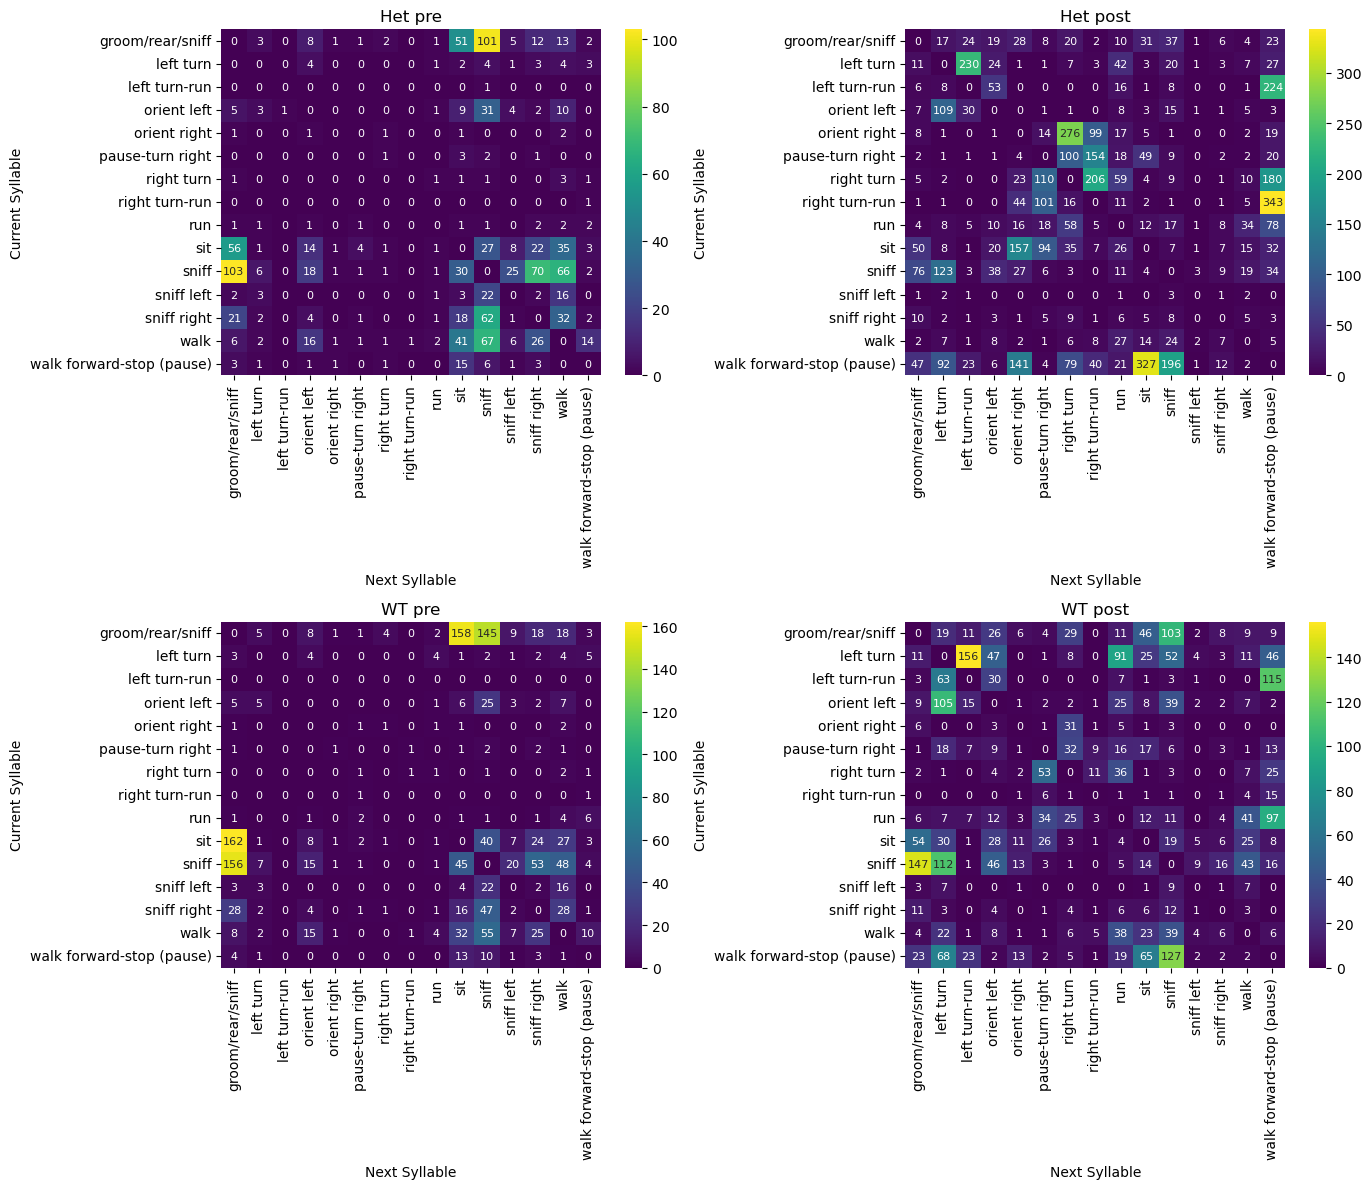

In [179]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

conditions = ['pre', 'post']
genotypes = ['Het', 'WT']

# Transpose the plots: make i index genotypes and j index conditions
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        genotype = genotypes[i]  # i now corresponds to genotype (Het, WT)
        condition = conditions[j]  # j now corresponds to condition (pre, post)
        
        data = grouped_transitions[(condition, genotype)]
        
        # Apply ceiling function to round up the values
        data_ceil = np.ceil(data).astype(int)
        
        # Plot the heatmap with rounded up integers
        sns.heatmap(
            data_ceil, 
            ax=ax, 
            cmap='viridis', 
            annot=True, 
            fmt='d',  # 'd' ensures integers are displayed
            annot_kws={"size": 8}  # Reduce annotation font size
        )
        ax.set_title(f'{genotype} {condition}')
        ax.set_xlabel('Next Syllable')
        ax.set_ylabel('Current Syllable')

plt.tight_layout()
plt.show()

In [ ]:
conditions = ['pre', 'post']
genotypes = ['Het', 'WT']

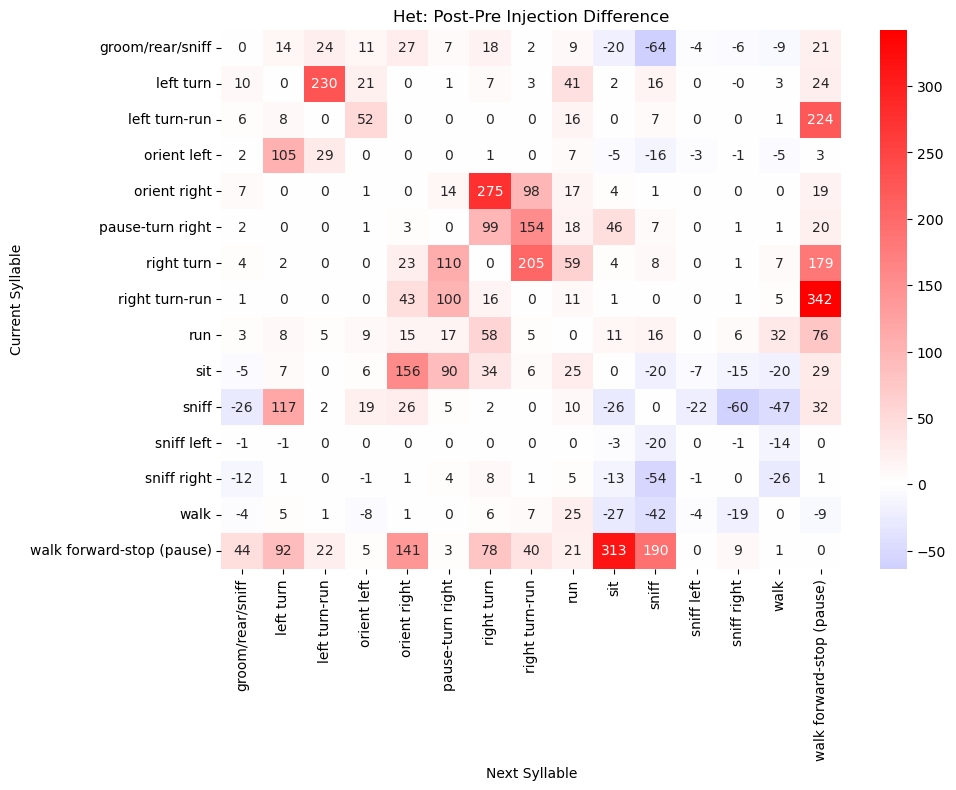

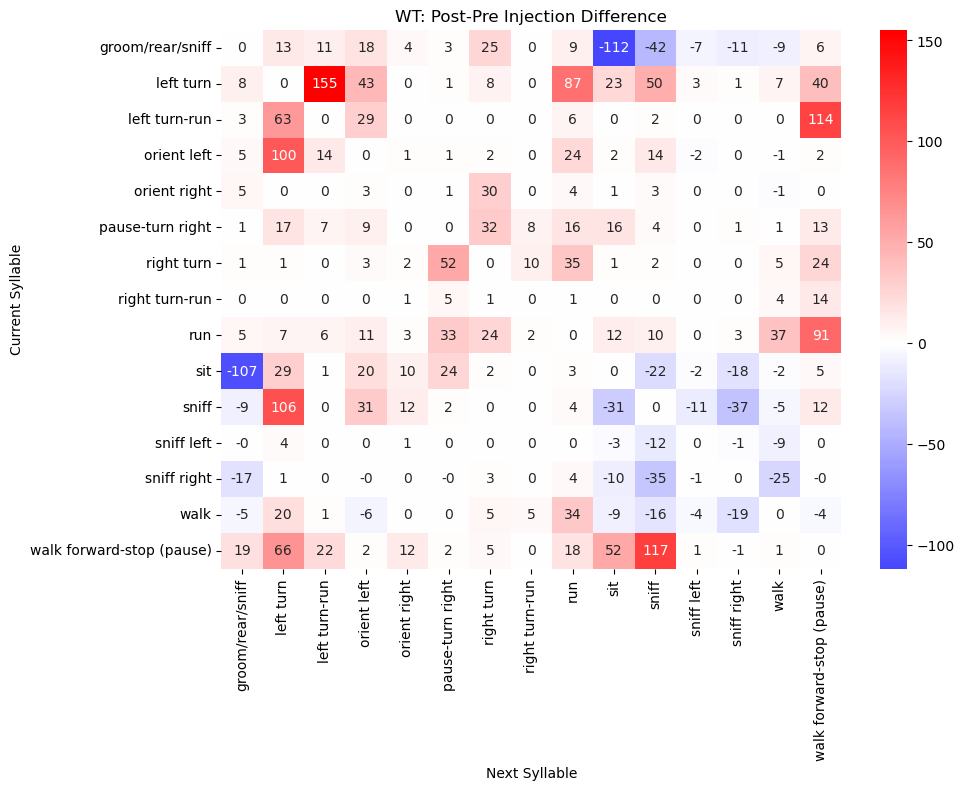

In [183]:
for genotype in genotypes:
    diff_matrix = grouped_transitions[('post', genotype)] - grouped_transitions[('pre', genotype)]

    # Visualize
    plt.figure(figsize=(10, 7))
    sns.heatmap(diff_matrix, cmap='bwr', center=0, annot=True, fmt='.0f')
    plt.title(f'{genotype}: Post-Pre Injection Difference')
    plt.xlabel('Next Syllable')
    plt.ylabel('Current Syllable')
    plt.show()

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_6928/648587719.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  favored_genotype = diff_of_diff_matrix.applymap(annotate_favored_genotype)


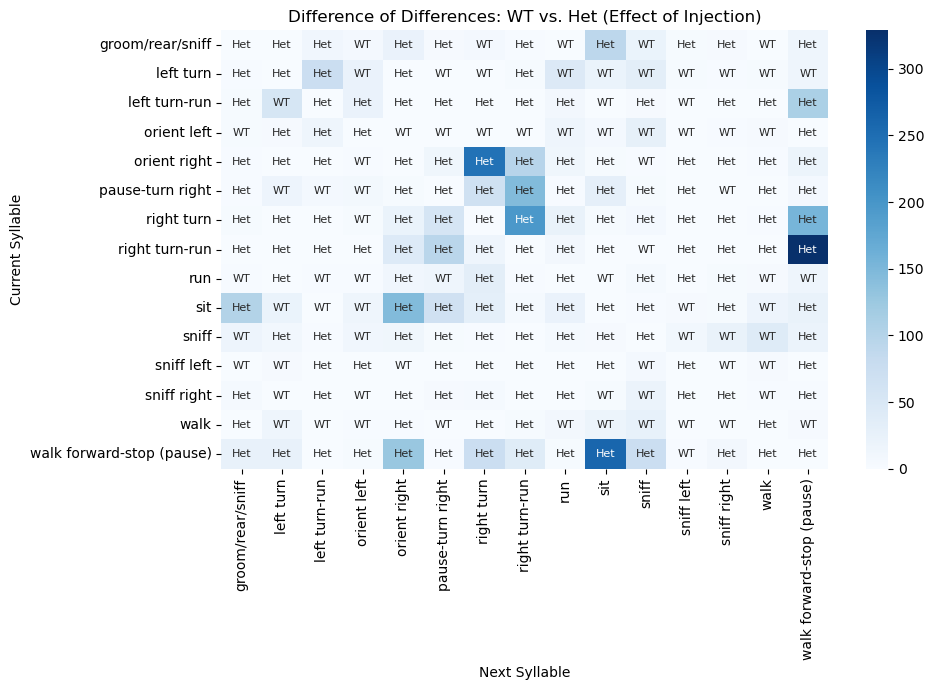

In [185]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Calculate the injection effect for each genotype (Post - Pre)
effect_WT = grouped_transitions[('post', 'WT')] - grouped_transitions[('pre', 'WT')]
effect_Het = grouped_transitions[('post', 'Het')] - grouped_transitions[('pre', 'Het')]

# Calculate the difference of differences: (WT effect) - (Het effect)
diff_of_diff_matrix = effect_WT - effect_Het

# Get the absolute value for magnitude
abs_diff_matrix = np.abs(diff_of_diff_matrix)

# Create a function to annotate the favored genotype (WT or Het)
def annotate_favored_genotype(val):
    if val > 0:
        return 'WT'
    else:
        return 'Het'

# Create a DataFrame with the labels (WT or Het)
favored_genotype = diff_of_diff_matrix.applymap(annotate_favored_genotype)

# Visualize the absolute difference of differences with labels for the favored genotype
plt.figure(figsize=(10, 7))
ax = sns.heatmap(abs_diff_matrix, cmap='Blues', annot=favored_genotype, fmt='', annot_kws={"size": 8})

# Title and axis labels
plt.title('Difference of Differences: WT vs. Het (Effect of Injection)')
plt.xlabel('Next Syllable')
plt.ylabel('Current Syllable')

# Show the plot
plt.tight_layout()
plt.show()


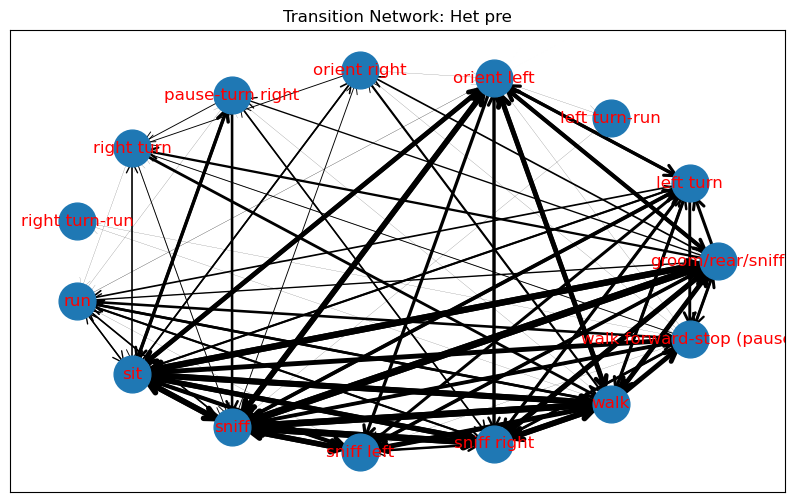

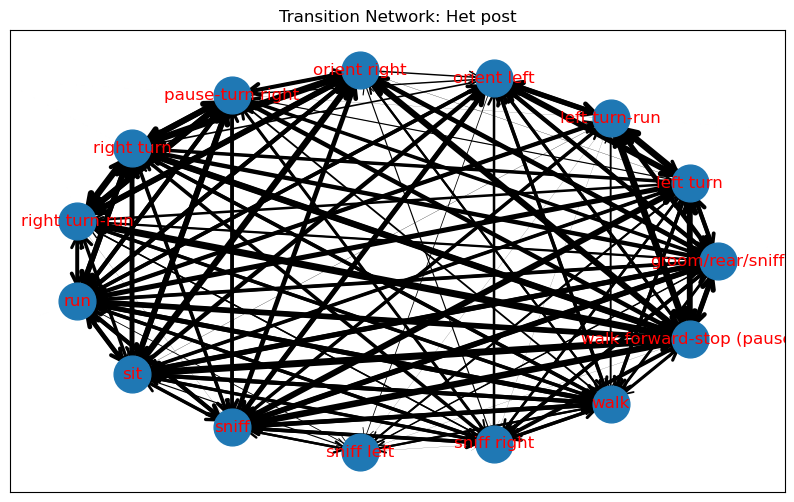

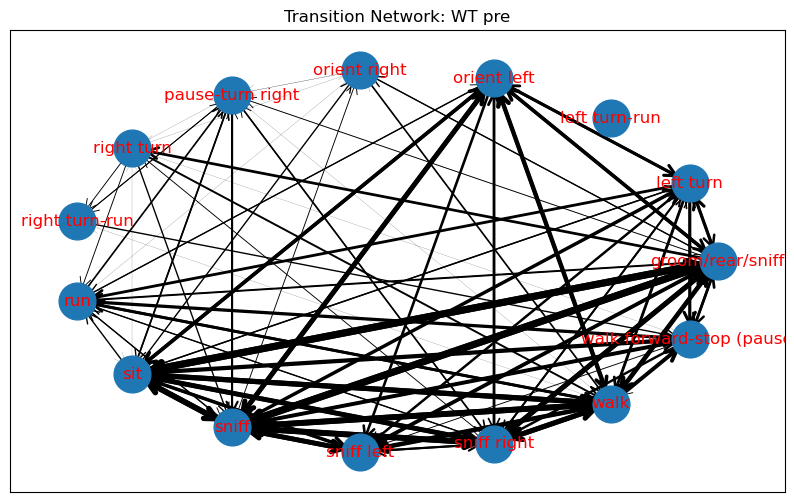

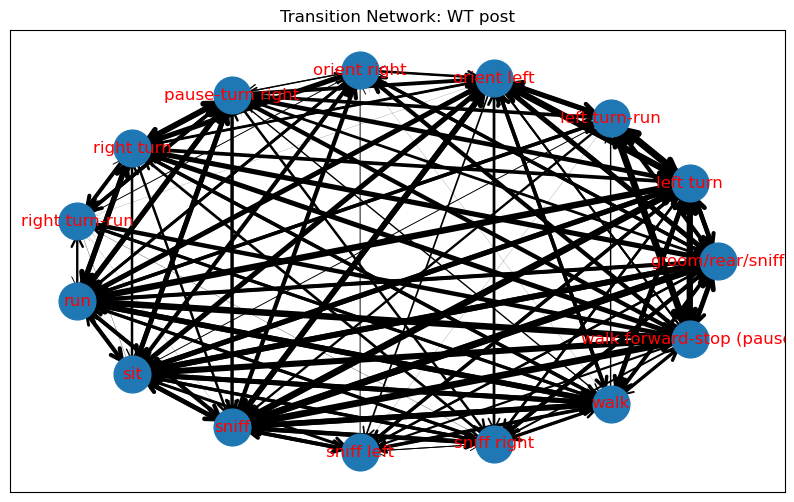

In [190]:
import networkx as nx

conditions = ['pre', 'post']
genotypes = ['Het', 'WT']

# Transpose the plots: make i index genotypes and j index conditions
for genotype in genotypes:
    for condition in conditions:
        # Create a directed graph from the transition matrix
        G = nx.from_pandas_adjacency(grouped_transitions[(condition, genotype)], create_using=nx.DiGraph())

        # Use a circular layout for the nodes
        pos = nx.circular_layout(G)

        # Draw the network
        plt.figure(figsize=(10, 6))

        # Draw the nodes
        nx.draw_networkx_nodes(G, pos, node_size=700)
        
        # Draw the labels
        nx.draw_networkx_labels(G, pos, font_color='red')

        # Get the edge weights from the adjacency matrix
        edge_weights = nx.get_edge_attributes(G, 'weight')

        # Log-scale the edge weights (add a small value to avoid log(0))
        log_edge_weights = [np.log10(G[u][v]['weight'] + 1e-5) for u, v in G.edges()]

        # Normalize the log-scaled weights for better visualization
        min_weight = min(log_edge_weights)
        max_weight = max(log_edge_weights)
        normalized_edge_weights = [(weight - min_weight) / (max_weight - min_weight + 1e-5) * 5 + 0.1 
                                   for weight in log_edge_weights]  # Scale factor for width

        # Draw the edges with log-scaled thickness
        edges = nx.draw_networkx_edges(
            G, pos, arrowstyle='->', arrowsize=20,
            width=normalized_edge_weights
        )

        # Add title
        plt.title(f'Transition Network: {genotype} {condition}')
        plt.show()



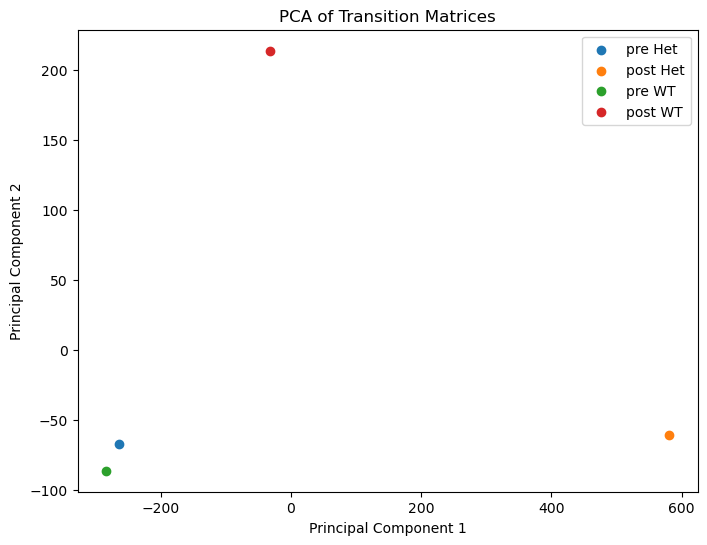

In [191]:
from sklearn.decomposition import PCA

# Flatten the matrices and stack them
data = []
labels = []
for key, matrix in grouped_transitions.items():
    data.append(matrix.values.flatten())
    labels.append(f'{key[0]} {key[1]}')

data = np.array(data)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)

plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):
    plt.scatter(principal_components[i, 0], principal_components[i, 1], label=label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Transition Matrices')
plt.legend()
plt.show()

### top transitions

In [47]:
import pandas as pd

def get_top_10_transitions(transition_matrix, top_n=10):
    # Flatten the matrix and convert it into a long format DataFrame
    transitions = transition_matrix.stack().reset_index()
    transitions.columns = ['from_syllable', 'to_syllable', 'probability']
    
    # Sort the transitions by probability in descending order
    top_transitions = transitions.sort_values(by='probability', ascending=False).head(top_n)
    
    return top_transitions

# Example usage:
# Assume 'transition_matrix' is a DataFrame returned from the previous function

for k, df in dfs_split.items():
    top_10_transitions = get_top_10_transitions(all_transition_matrices[k], top_n=10)

    # Display the top 10 transitions
    print(k)
    print(top_10_transitions)
    print('#' * 35)


('222', 'pre', 'Het', 'Left')
                 from_syllable       to_syllable  probability
103                 orint left         left turn     1.000000
31                   left turn       sniff right     0.800000
283  walk forward-stop (pause)               sit     0.588235
96                orient right               sit     0.500000
85                orient right  groom/rear/sniff     0.500000
131           pause-turn right             sniff     0.500000
184                        run       sniff right     0.428571
236                 sniff left              walk     0.409091
233                 sniff left             sniff     0.409091
250                sniff right             sniff     0.400000
###################################
('222', 'post', 'Het', 'Left')
                 from_syllable                to_syllable  probability
67               left turn-run  walk forward-stop (pause)     1.000000
236                 sniff left                       walk     1.000000
169     

## Statistical tests

### Compare rankings

In [38]:
def count_and_rank_syllables(dfs, column='syllable_name'):
    # Combine all DataFrames and count syllables
    combined_df = pd.concat(dfs)
    syllable_counts = combined_df[column].value_counts()
    
    # Rank syllables based on counts
    syllable_ranking = syllable_counts.rank(ascending=False).astype(int)
    
    return syllable_counts, syllable_ranking

def compare_syllable_rankings_additive(pre_dfs, post_dfs, column='syllable_name'):
    # Count and rank syllables in pre-amphetamine DataFrames
    pre_counts, pre_ranking = count_and_rank_syllables(pre_dfs, column)
    
    # Count and rank syllables in post-amphetamine DataFrames
    post_counts, post_ranking = count_and_rank_syllables(post_dfs, column)
    
    # Create a DataFrame to compare rankings
    comparison_df = pd.DataFrame({
        'pre_count': pre_counts,
        'pre_ranking': pre_ranking,
        'post_count': post_counts,
        'post_ranking': post_ranking
    }).fillna(0)  # Fill missing syllables with 0
    
    # Calculate the additive change in ranking
    comparison_df['ranking_change'] =  comparison_df['pre_ranking'] - comparison_df['post_ranking']
    
    # Sort by the absolute value of ranking change but keep the actual additive values
    comparison_df = comparison_df.reindex(comparison_df['ranking_change'].abs().sort_values(ascending=False).index)
    
    return comparison_df

In [39]:
het_ids = ['237', '239', '202', '218', '220', '222']

In [40]:
pre_dfs = []
post_dfs = []

for k, df in dfs_split.items():
    # if str(k.split(sep='_')[0]) not in het_ids:
    #     continue
    if k[-3:] == 'pre':
        pre_dfs.append(df)
    else:
        post_dfs.append(df)

In [ ]:
comparison_df = compare_syllable_rankings_additive(pre_dfs, post_dfs, column='syllable_name')


print(comparison_df.head(50))  # Top 10 syllables with the largest ranking change